In [1]:
import torch
import dgl
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('../../../Untitled Folder 1/bot_iot/bot.csv')

/tmp/ipykernel_1880/3993269919.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../Untitled Folder 1/bot_iot/bot.csv')


In [3]:
data.drop(columns=['subcategory','pkSeqID','stime','flgs','category','state','proto','seq','sum','pkts','TnP_PSrcIP',
                   'AR_P_Proto_P_DstIP', 'dbytes','dur', 'flgs_number', 'rate', 'AR_P_Proto_P_Sport', 'proto_number',
                   'state_number', 'AR_P_Proto_P_Dport', 'dpkts', 'max', 'mean', 'min', 'drate'],inplace=True)

In [4]:
data.rename(columns={"attack": "label"},inplace = True)

In [5]:
data.label.value_counts()

label
1    3668045
0        477
Name: count, dtype: int64

In [6]:
# le = LabelEncoder()
# le.fit_transform(data.label.values)
# data['label'] = le.transform(data['label'])

In [7]:
data['saddr'] = data.saddr.apply(str)
data['sport'] = data.sport.apply(str)
data['daddr'] = data.daddr.apply(str)
data['dport'] = data.dport.apply(str)

In [8]:
data['saddr'] = data['saddr'] + ':' + data['sport']
data['daddr'] = data['daddr'] + ':' + data['dport']

In [9]:
data.drop(columns=['sport','dport'],inplace=True)
label_ground_truth = data[["saddr", "daddr","label"]]
# data = pd.get_dummies(data, columns = ['flgs_number','state_number', 'proto_number'])

In [10]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [11]:
data.fillna(0,inplace = True)

In [12]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [13]:
data.drop(columns=['index'],inplace=True)

In [14]:
data

,saddr,daddr,bytes,ltime,stddev,spkts,sbytes,srate,TnBPSrcIP,TnBPDstIP,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,label
0,192.168.100.147:49960,192.168.100.7:80,1980,1.528089e+09,0.068909,5,650,0.566862,157426,201841,770,772,772,1.142970,96,75,770,602,1
1,192.168.100.7:-1,192.168.100.147:-1,120,1.528089e+09,0.000000,1,60,0.000000,360,120,2,8,8,0.003857,1,2,2,6,1
2,192.168.100.147:49962,192.168.100.7:80,2126,1.528089e+09,0.064494,5,796,0.567549,157426,201841,770,772,772,1.142970,96,75,770,602,1
3,192.168.100.147:49964,192.168.100.7:80,2024,1.528089e+09,0.064189,5,694,0.567570,157426,201841,770,772,772,1.142970,96,75,770,602,1
4,192.168.100.147:49966,192.168.100.7:80,2319,1.528089e+09,0.063887,5,989,0.567630,157426,201841,770,772,772,1.142970,96,75,770,602,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,192.168.100.150:35064,192.168.100.3:22,434,1.529381e+09,0.000000,3,228,151.917969,79240,79240,471,475,471,9.889330,19,19,30,30,1
3668518,192.168.100.150:35066,192.168.100.3:22,434,1.529381e+09,0.000000,3,228,3484.320557,79240,79240,471,475,471,9.889330,19,19,30,30,1
3668519,192.168.100.150:35070,192.168.100.3:22,5472,1.529381e+09,0.000000,14,1802,4.522837,79240,79240,471,475,471,9.889330,19,19,441,441,1
3668520,192.168.100.3:43001,192.168.100.150:4433,134,1.529381e+09,0.000000,1,74,0.000000,1228,134,2,475,4,22346.400000,1,3,2,4,1


In [15]:
scaler = StandardScaler()
cols_to_norm = ['stddev',
 'ltime',
 'N_IN_Conn_P_DstIP',
 'N_IN_Conn_P_SrcIP',
 'TnP_Per_Dport',
 'TnBPDstIP',
 'TnP_PerProto',
 'spkts',
 'srate',
 'Pkts_P_State_P_Protocol_P_SrcIP',
 'TnP_PDstIP',
 'TnBPSrcIP',
 'AR_P_Proto_P_SrcIP',
 'bytes',
 'Pkts_P_State_P_Protocol_P_DestIP',
 'sbytes']
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [17]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [18]:
cols_to_norm

['stddev',
 'ltime',
 'N_IN_Conn_P_DstIP',
 'N_IN_Conn_P_SrcIP',
 'TnP_Per_Dport',
 'TnBPDstIP',
 'TnP_PerProto',
 'spkts',
 'srate',
 'Pkts_P_State_P_Protocol_P_SrcIP',
 'TnP_PDstIP',
 'TnBPSrcIP',
 'AR_P_Proto_P_SrcIP',
 'bytes',
 'Pkts_P_State_P_Protocol_P_DestIP',
 'sbytes']

In [19]:
G = nx.from_pandas_edgelist(X_train, "daddr", "saddr", ['h','label'],create_using=nx.MultiDiGraph)

In [20]:
G.number_of_edges()

2567965

In [21]:
G1 = nx.from_pandas_edgelist(X_train, "daddr", "saddr",create_using=nx.MultiGraph)

In [22]:
G1.number_of_edges()

2567965

In [23]:
G1 = G1.to_directed()

In [24]:
G = from_networkx(G,edge_attrs=['h','label'] )

In [25]:
G1 = from_networkx(G1)

In [26]:
G1 = dgl.add_self_loop(G1)

In [27]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [28]:
G

Graph(num_nodes=272566, num_edges=2567965,
      ndata_schemes={}
      edata_schemes={'h': Scheme(shape=(16,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [29]:
G1

Graph(num_nodes=272566, num_edges=5408496,
      ndata_schemes={}
      edata_schemes={})

In [30]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [31]:
from dgl.utils import expand_as_pair
from dgl.nn.functional import edge_softmax
class GATConv(nn.Module):
    def __init__(
        self,
        in_feats,
        out_feats,
        feat_drop=0.0,
        attn_drop=0.0,
        negative_slope=0.2,
    ):
        super(GATConv, self).__init__()
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        
        self.fc = nn.Linear(
            self._in_src_feats, out_feats, bias=False
        )
        
        self.attn = nn.Parameter(
            th.FloatTensor(size=(1, out_feats))
        )

        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        self.leaky_relu = nn.LeakyReLU(negative_slope)

        
        self.reset_parameters()
       
    
    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        
        nn.init.xavier_normal_(self.fc.weight, gain=gain)

        nn.init.xavier_normal_(self.attn, gain=gain)

    
    def message_func(self, edges):
        return {'m': edges.data['a'] * edges.data['ft']}
    
    def forward(self, graph, efeat):
        with graph.local_scope(): 
            efeat = self.feat_drop(efeat)
            efeat = self.fc(efeat)
            graph.edata['ft'] = efeat
            e = (efeat * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['e']= e         
            e = self.leaky_relu(graph.edata.pop('e'))
            graph.edata['a'] = self.attn_drop(edge_softmax(graph, e))
            # message passing
            graph.update_all(self.message_func, fn.sum('m', 'ft'))
            rst = graph.ndata['ft']
            return rst,efeat

In [32]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 3, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        h_e = edges.data['e']
        score = self.W(th.cat([h_u, h_v, h_e], 1))
        return {'score': score}

    def forward(self, graph, h, e):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.edata['e'] = e
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [33]:
class SAGEConv(nn.Module):
   
    def __init__(
        self,
        in_feats,
        out_feats,
        k=2,
        feat_drop=0.1,
        cached=False,
        bias=True,
    ):
        super(SAGEConv, self).__init__()
        self.fc = nn.Linear(in_feats, out_feats, bias=bias)
        self._k = k
        self.feat_drop = nn.Dropout(feat_drop)
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)
        
    def forward(self, graph, feat, edge_weight=None):
        with graph.local_scope():
          
            msg_fn = fn.copy_u("h", "m")
            
            for _ in range(self._k):
                h_self = self.feat_drop(feat)
                graph.ndata["h"] = h_self
                graph.update_all(msg_fn, fn.mean("m", "neigh"))
#                 feat = self.feat_drop(graph.ndata.pop("neigh"))
                h_neigh = graph.ndata.pop("neigh")
                feat = h_neigh
            return self.fc(feat)

In [34]:
class Model(nn.Module):
    def __init__(self, edim_in, edim_out, ndim_out):
        super().__init__()
        self.gat = GATConv(edim_in, ndim_out)
        self.conv1 = SAGEConv(ndim_out, edim_out, k=2)
        self.pred = MLPPredictor(edim_out, 2)
    def forward(self, g, g1, efeats):
        h,e = self.gat(g, efeats)
        h = F.relu(h)
        h = self.conv1(g1, h)
        return self.pred(g, h, e), h

In [35]:
class MLP(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features, out_classes)
        self.feat_drop = nn.Dropout(0.1)


    def forward(self, h):
        return self.feat_drop(self.W(h))

In [36]:
class Model1(nn.Module):
    def __init__(self, edim_in, edim_out, ndim_out):
        super().__init__()
        self.gat = GATConv(edim_in, ndim_out)
        self.conv1 = MLP(ndim_out, edim_out)
        self.pred = MLPPredictor(edim_out, 2)
    def forward(self, g, efeats):
        h,e = self.gat(g, efeats)
        h = F.relu(h)
        h = self.conv1(h)
        return self.pred(g, h, e),h

In [37]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(G.edata['label'].cpu().numpy()),
                                                  y = G.edata['label'].cpu().numpy())
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)
criterion1 = nn.KLDivLoss(reduction='batchmean')

In [38]:
# criterion = nn.CrossEntropyLoss()

In [39]:
G = G.to('cuda:0')
G1 = G1.to('cuda:0')

In [40]:
teacher = torch.load('binary.pth')

In [41]:
import time
start_time = time.time()

edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model1(G.edata['h'].shape[1], 8, 8).cuda()
opt = th.optim.Adam(model.parameters())

with torch.no_grad():
    out_t, h_feature_t = teacher(G, G1, edge_features)

for epoch in range(1,12000):
    pred,h_feature_s = model(G, edge_features)
    loss_h = criterion(pred[train_mask] ,edge_label[train_mask])
    loss_t1 = criterion1(F.log_softmax(h_feature_s, dim=1) ,F.softmax(h_feature_t, dim=1))
    loss = 0.7*loss_h + 0.3*loss_t1
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('epoc:{} Training acc:{} loss:{}'.format(epoch, compute_accuracy(pred[train_mask], edge_label[train_mask]), loss))
        
end_time = time.time()
execution_time = end_time - start_time
print(f"程序执行时间为：{execution_time} 秒")

epoc:100 Training acc:0.9138773083686829 loss:0.30112749338150024
epoc:200 Training acc:0.9414722919464111 loss:0.22474297881126404
epoc:300 Training acc:0.9451401829719543 loss:0.18550066649913788
epoc:400 Training acc:0.976645290851593 loss:0.1427203267812729
epoc:500 Training acc:0.9813061952590942 loss:0.12238001823425293
epoc:600 Training acc:0.9832139015197754 loss:0.11158585548400879
epoc:700 Training acc:0.9837392568588257 loss:0.1044960618019104
epoc:800 Training acc:0.9847925901412964 loss:0.09794500470161438
epoc:900 Training acc:0.9863506555557251 loss:0.09380430728197098
epoc:1000 Training acc:0.9862026572227478 loss:0.08875012397766113
epoc:1100 Training acc:0.9848915338516235 loss:0.09080341458320618
epoc:1200 Training acc:0.9888701438903809 loss:0.08462009578943253
epoc:1300 Training acc:0.9914897680282593 loss:0.08030154556035995
epoc:1400 Training acc:0.9900789260864258 loss:0.07626968622207642
epoc:1500 Training acc:0.991719126701355 loss:0.07257839292287827
epoc:160

In [42]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [43]:
G_test = nx.from_pandas_edgelist(X_test, "daddr", "saddr", ['h','label'],create_using=nx.MultiDiGraph)
G_test = from_networkx(G_test, edge_attrs=['h','label'])
actual = G_test.edata.pop('label')

In [44]:
G_test = G_test.to('cuda:0')

In [45]:
th.cuda.empty_cache()

In [46]:
import timeit

edge_features_test = G_test.edata['h']

torch.cuda.synchronize()
start_time = timeit.default_timer()

with torch.no_grad():
    test_pred,h =model(G_test, edge_features_test)

torch.cuda.synchronize()
elapsed = timeit.default_timer() - start_time

In [47]:
print(str(elapsed) + ' seconds')

0.0025256860026274808 seconds


In [48]:
print(elapsed/len(X_test))

2.2949161221340472e-09


In [49]:
test_pred = test_pred.argmax(1)

In [50]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [51]:
from sklearn import metrics

accuracy = metrics.accuracy_score(actual, test_pred)
precision = metrics.precision_score(actual, test_pred)
f1_score = metrics.f1_score(actual, test_pred)
recall = metrics.recall_score(actual, test_pred)

# 假阳性率（FAR）是混淆矩阵中假阳性（FP）与实际为负类（实际为负类的样本数为实际负例（TN）+假阳性（FP））的比率
tn, fp, fn, tp = metrics.confusion_matrix(actual, test_pred).ravel()
far = fp / (fp + tn)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1_score}")
print(f"Recall: {recall}")
print(f"FAR: {far}")

Accuracy: 0.999836446453932
Precision: 1.0
F1-Score: 0.9999182059102593
Recall: 0.9998364251999702
FAR: 0.0


In [52]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [53]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

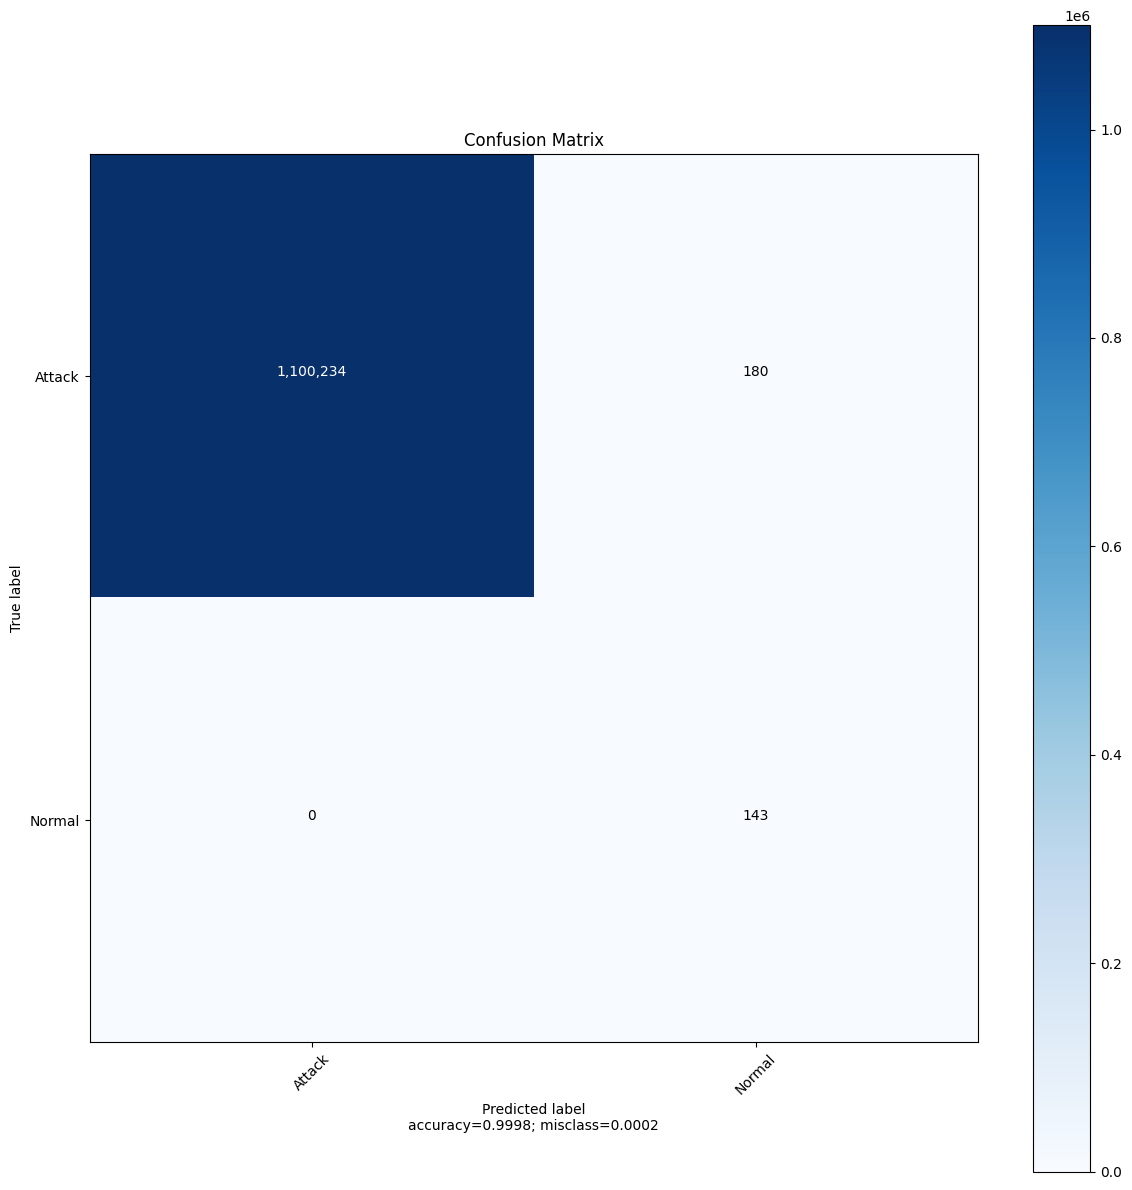

In [54]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [55]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          title_fontsize=14):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 5))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label', fontsize=14)
    plt.show()

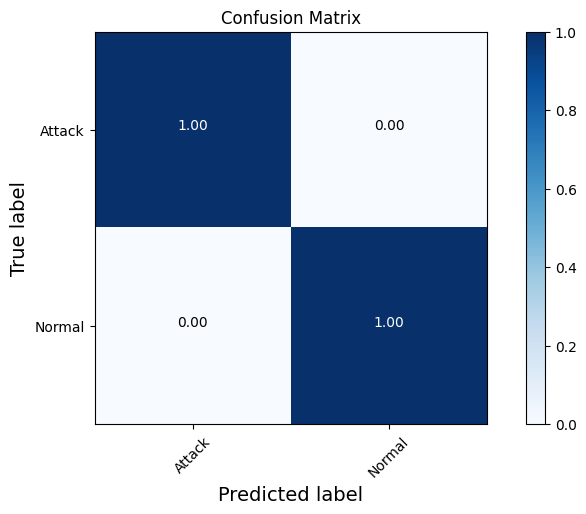

In [56]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = True,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [57]:
model.parameters()
print(sum(p.numel() for p in model.parameters())*4)

1032


In [58]:
# torch.save(model, 'binary.pth')

In [59]:
# model

In [60]:
model

Model1(
  (gat): GATConv(
    (fc): Linear(in_features=16, out_features=8, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (conv1): MLP(
    (W): Linear(in_features=8, out_features=8, bias=True)
    (feat_drop): Dropout(p=0.1, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=24, out_features=2, bias=True)
  )
)